In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

# compute Confusion Matrix for AD, CN and MCI using 3D volume MRI 

In [2]:
import os 
import shutil
import nibabel as nib
import numpy as np
import pandas as pd 

# El path al directorio donde estan las imagenes

dataset_dir = 'C:\ADNI\Imagenes3D'
dataset_labelfile = "C:\ADNI/ADNI1_Complete_1Yr_1.5T.csv"
dataset_labelfile_idfield = 'Image Data ID'
dataset_labelfile_labelfield = 'Group'

#Training parameters

n_dataset_parts = 5 #must be integer
crossval_dataset_frac = 1/n_dataset_parts

FilePathsFromId = {} ## 'ID':path
LabelsFromId = {} ## 'ID':label

IntLabels = {'CN':0, 'AD':1,'MCI':2}

target_shape = (192,192,160)
target_affine = np.array([ [ 4.29048360e-08,  3.24291396e-04, -1.20006235e+00, 9.47253036e+01],
                        [-3.27969076e-04, -1.23945871e+00, -3.13983739e-04, 1.38530121e+02],
                        [-1.25348123e+00,  3.24300145e-04,  4.10763858e-08, 1.08530121e+02],
                        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, 1.00000000e+00]
                ])


# Data management functions 

In [3]:
def GenerateDictionariesFromDataset(dataset_dir,dataset_labelfile,dataset_labelfile_idfield,dataset_labelfile_labelfield):
    
    
    CSVDB = GenerateCSVDB(dataset_labelfile,dataset_labelfile_idfield)
    
    FilePaths = GenerateFilePathList(dataset_dir)
        
    return GenerateDictionariesFromFileList(FilePaths,CSVDB,dataset_labelfile_labelfield)
    

def GenerateDictionariesFromFileList(FilePaths,CSVDB,CSVDBField):

    FilePathsFromId = {} ## 'ID':path
    LabelsFromId = {} ## 'ID':label
        
    for filePath in FilePaths:

        Id = IdFromFilePath(filePath) 
        Label = LabelFromId(Id,CSVDB,CSVDBField)
        
        FilePathsFromId[Id] = filePath
        LabelsFromId[Id] = IntLabels[Label]

    return FilePathsFromId,LabelsFromId

def IdFromFilePath(FilePath):
    #expecting filename like id.nii
    Id = FilePath.split('\\')[-1].split('.')[0]
    Id = np.int64(Id)
    return Id

def LabelFromId(Id,CSVDB,CSVDBField):
    return CSVDB.at[Id, CSVDBField]

def GenerateCSVDB(dataset_labelfile,dataset_labelfile_idfield):
    #read CSV file
    CSVDB = pd.read_csv(dataset_labelfile, dtype={dataset_labelfile_idfield:int})
    #Generate index on id field
    CSVDB.set_index(dataset_labelfile_idfield, inplace=True)
    
    return CSVDB

def GenerateFilePathList(dataset_dir):

    FilePaths = []
    for dirname, dirnames, filenames in os.walk(dataset_dir):
        # print path to all subdirectories first.
        for subdirname in dirnames:
            FilePaths.append(os.path.join(dirname, subdirname))

        # print path to all filenames.
        for filename in filenames:
            FilePaths.append(os.path.join(dirname, filename))
            
    return FilePaths

# Data dictionaries

In [4]:
import random

FilePathsFromId,LabelsFromId = GenerateDictionariesFromDataset(dataset_dir,
                                                               dataset_labelfile,
                                                               dataset_labelfile_idfield,
                                                               dataset_labelfile_labelfield)

#print(FilePathsFromId)
#print(LabelsFromId)

#Ids = list(FilePathsFromId.keys())

#print(Ids)
#print(len(Ids))

c0=0
c1=0
c2=0
Ids0 = []
Ids1 = []
Ids2 = []
indice = 0
for k,v in LabelsFromId.items():
    #print('k:',k,'v:',v)
    if v==0:
        c0 += 1
        Ids0.append(k)  
    if v==1:
        c1 += 1
        Ids1.append(k)  
    if v==2:
        c2 += 1
        Ids2.append(k)  
    
    indice += 1
        
print('CN:',c0,'AD:',c1,'MCI:',c2)
Tot = c0+c1+c2
print('Tot:',Tot)
f0=c0/Tot
f1=c1/Tot
f2=c2/Tot
print('f0:',f0,'f1:',f1,'f2:',f2)

#append ids mantaining proportion
Ids = []
n0 = 0
n1 = 0
n2 = 0
indice = 0

while indice<Tot :
    
    rn = random.random()        # Random float x, 0.0 <= x < 1.0
    
    if rn < f0:
        if n0 < len(Ids0):
            Ids.append(Ids0[n0])      
            n0 += 1
            indice += 1
            
    if rn>=f0 and rn<(f0+f1):
        if n1 < len(Ids1):
            Ids.append(Ids1[n1])      
            n1 += 1
            indice += 1

    if rn>=(f0+f1): 
        if n2 < len(Ids2):
            Ids.append(Ids2[n2])      
            n2 += 1
            indice += 1
    
#print('indice:',indice)
#print(len(Ids)




CN: 703 AD: 476 MCI: 1113
Tot: 2292
f0: 0.3067190226876091 f1: 0.20767888307155322 f2: 0.4856020942408377


# Import trained model

In [5]:
from keras.models import load_model

model = load_model('CN_AD_MCI_Conv3D_CV_GP2_0.h5')

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling3d_1 (Average (None, 96, 96, 80, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 96, 96, 80, 32)    896       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 48, 48, 40, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 46, 46, 38, 64)    55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 23, 23, 19, 64)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 21, 21, 17, 128)   221312    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 10, 10, 8, 128)    0         
__________

# MAIN

In [8]:
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from my_classes import DataGenerator

from sklearn.metrics import confusion_matrix


# Parameters
batch_size = 15
params = {'dim': (192,192,160),
          'batch_size': batch_size,
          'n_classes': 3,
          'n_channels': 1,
          'shuffle': False,
          'target_shape': target_shape,
          'target_affine': target_affine}

partition = {}
labels = {}

nf = len(Ids)
print('Total images:',nf)

nf_part = int( (nf/n_dataset_parts) //1)
print('training images:',nf-nf_part)
print('validation images:',nf_part)

print('batch_size:',batch_size)

#epochs_per_run = 50

#steps_per_epoch = int(((nf-nf_part)/batch_size)//1)

#print('steps_per_epoch:',steps_per_epoch)

validation_steps = int(((nf_part)/batch_size)//1)

print('validation_steps:',validation_steps)

#cvscores = []

#save in file initial weights 
#model.save_weights('CN_AD_MCI_Conv3D_CV_GP2_start_weights.h5')

#for nrun in range(n_dataset_parts):

#we only have  NN trained for run = 0
nrun=0

partition['train'] = Ids[0:nrun*nf_part]+Ids[(nrun+1)*nf_part:nf] 
partition['validation'] = Ids[nrun*nf_part:(nrun+1)*nf_part]

# Generators
training_generator = DataGenerator(FilePathsFromId, LabelsFromId, partition['train'],  **params)
validation_generator = DataGenerator(FilePathsFromId, LabelsFromId, partition['validation'],  **params)

    
#scores=model.evaluate_generator(validation_generator, steps=validation_steps) # sobre todas las imagenes el set de validacion

#print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
#cvscores.append(scores[1] * 100)

y_espe = np.concatenate([np.argmax(validation_generator[i][1], axis=1) for i in range(validation_steps)])
print(y_espe)

y_pred = np.argmax(model.predict_generator(validation_generator,
                                           steps=validation_steps,
                                           max_queue_size=10,
                                           workers=6, 
                                           use_multiprocessing=False, 
                                           verbose=1
                                          ),
                   axis=1) 

print(y_pred)

cm = confusion_matrix(y_espe,y_pred)

print(cm)
    

Total images: 2292
training images: 1834
validation images: 458
batch_size: 15
steps_per_epoch: 122
validation_steps: 30
Using  Keras Generator for NIfti images V.12
Using  Keras Generator for NIfti images V.12
[0 0 2 2 0 2 2 2 0 1 0 2 0 2 1 2 0 0 0 0 1 1 1 2 0 1 0 1 0 1 1 1 0 2 2 1 2
 2 0 2 1 2 2 2 2 2 2 2 0 2 0 0 2 0 2 2 0 2 0 0 1 2 2 2 2 1 0 2 2 1 1 2 0 1
 2 2 0 1 1 0 0 0 2 0 2 2 2 1 1 2 1 2 2 0 0 2 2 2 2 0 1 2 1 1 2 1 0 2 2 2 2
 2 0 2 1 0 2 0 0 2 2 0 0 0 0 0 1 2 2 1 0 0 0 1 1 2 2 2 2 2 0 2 2 0 0 2 2 2
 0 2 2 1 0 1 2 0 0 2 2 1 2 2 2 1 2 2 2 2 2 2 1 2 0 2 2 2 2 0 2 2 2 2 0 2 2
 0 1 2 2 0 2 0 0 2 2 2 2 0 2 0 2 2 0 1 1 2 0 0 2 2 1 0 2 1 2 2 1 1 2 2 0 0
 1 0 2 2 0 0 1 2 0 0 1 2 0 0 1 1 1 1 1 2 2 1 0 0 1 0 2 0 2 1 2 2 2 0 2 2 1
 2 0 2 1 2 2 2 0 1 0 1 0 2 0 2 0 1 1 2 2 2 1 0 2 2 0 2 0 2 0 2 0 0 0 1 1 2
 2 0 2 0 1 2 0 0 2 2 0 2 0 2 0 2 2 0 2 0 2 0 2 2 1 0 0 2 2 0 2 1 2 0 2 2 0
 2 2 2 0 0 1 1 2 0 2 2 2 2 1 1 2 2 0 1 1 2 0 2 2 0 2 2 2 0 2 1 0 2 2 2 2 2
 2 2 1 2 2 1 0 0 0 2 2 1 2 2 2 2 2 0 1 

Confusion matrix, without normalization
[[105   7  23]
 [ 14  57  19]
 [ 27  21 177]]
Normalized confusion matrix
[[0.78 0.05 0.17]
 [0.16 0.63 0.21]
 [0.12 0.09 0.79]]


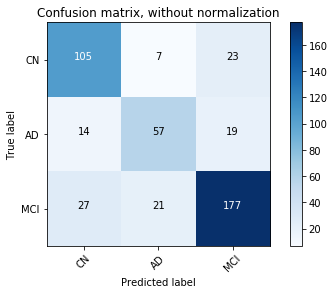

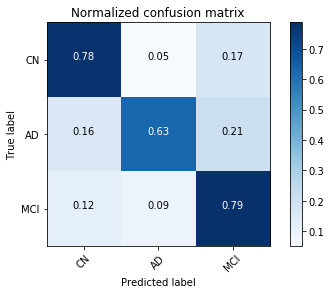

In [10]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['CN','AD','MCI']
# Compute confusion matrix
##FA# cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()